In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Transformation utilties
-------------------------

In [2]:
units = {'x':'mm','y':'mm','r':'mm','z':'mm','px':'keV/c','py':'keV/c','pz':'MeV/c','t':'ps','q':'pC','thetax':'mrad','thetay':'mrad'}
from distgen.generator import Generator
from distgen.plot import plot_2d
from distgen.physical_constants import unit_registry as unit
from matplotlib import pyplot as plt

A set of transformations can be applied to a beam when it is created by adding the transformation descriptions to the nested input dictionary structure.  All inputs to the transform function other than the variable names should go in the 'params' dictionary in the transform definition.  Physical quantities with units should be dictionaries with a 'value' and 'units' key/value pair supplied.  Transformations are applied in the order they are input in the transforms dictionary.  In the example below, two transforms are include: scaling a round beam so that it is oval, and then rotated the beam by 45 deg.

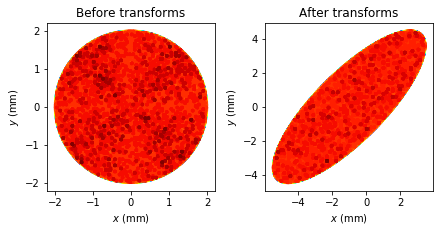

In [3]:
filename = "data/beer.can.in.json"
gen = Generator(filename, verbose=0) 

initial_beam = gen.beam()

gen.input['transforms']={
    '3mm_scale':{'type':'scale', 
                         'variables':'x', 
                         'params':{'scale': {'value':3, 'units':'dimensionless',}
                                  }
                },
    'rot45deg': {'type': 'rotate2d', 
                        'variables': 'x:y', 
                        'params': {'angle': {'value': 45, 'units': 'deg'}}
                },
    'xshift':   {'type': 'translate', 
                        'variables': 'x', 
                        'params': {'delta': {'value': -1, 'units': 'mm'}}
                },
}

final_beam = gen.beam()

fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True)

plot_2d(initial_beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[0]);
ax[0].set_title('Before transforms');

plot_2d(final_beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[1]);
ax[1].set_title('After transforms');

Distgen provides a set of basic transformation utilities that can be applied the particle coordinates of a beam object.  Here the basic examples are discused: the transformation functions are defined as well as how to use them from the standard Distgen input structure.  Note the these transformation operations do not in general commute.

The primary example used is that of a uniform radial distribution.

# Translations

Translations of the coordinate $u$ are defined by: $u\rightarrow u + \Delta u$.

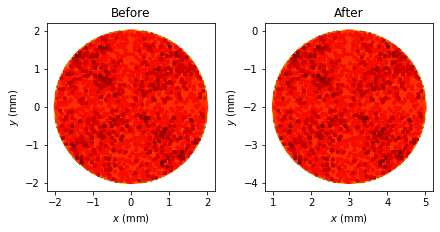

In [4]:
# Translations: a translation of a single coordinate are handled by transforms.translate
from distgen.transforms import translate

filename = "data/beer.can.in.json"
gen=Generator(filename,verbose=0)
beam1=gen.beam()

beam2 = gen.beam()
translate(beam2,'x',+3*unit('mm'))
translate(beam2,'y',-2*unit('mm'))

fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True)
plot_2d(beam1,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[0]);
ax[0].set_title('Before')

plot_2d(beam2,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[1]);
ax[1].set_title('After');

# Scaling

Basic scaling is handled using transforms.scale.  To scale the $x$ coordinate of the beam by $\alpha$ use:

scale(beam,'x',$\alpha$) 

where $\alpha$ is a dimensionless quantity or float.  Note that if the $<x>\neq0$ then 
$<x>\rightarrow\alpha<x>$.  It is possible to fix the average value under scaling using:

scale(beam, 'x', $\alpha$, fix_average='True') 


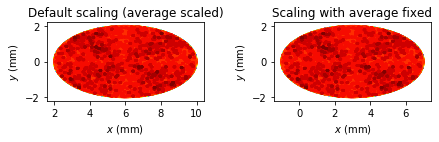

In [5]:
from distgen.transforms import scale
gen=Generator(filename,verbose=0)
beam1 = gen.beam()
translate(beam1,'x',3*unit('mm'))
scale(beam1,'x',2)

beam2 = gen.beam()
translate(beam2,'x',3*unit('mm'))
scale(beam2,'x',2,fix_average=True)

fig, ax = plt.subplots(1, 2, constrained_layout=True)
plot_2d(beam1,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[0]);
ax[0].set_title('Default scaling (average scaled)')

plot_2d(beam2,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[1]);
ax[1].set_title('Scaling with average fixed');


# Shift and Scale a single coordinate

It is possible to combine a translation with a scaling operation to shift and rescale a coordinate
to have a new standard deviation while keeping the form of the underlying coordinate distribution unchanged. This is accomplished using transforms.set_avg_and_std(...)

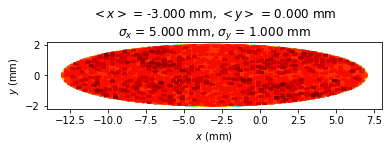

In [6]:
from distgen.transforms import set_avg_and_std
gen=Generator(filename,verbose=0)
beam = gen.beam()
set_avg_and_std(beam,'x',-3*unit('mm'),5*unit('mm'))
plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",title_on=True);

# Rotating coordinates

Rotation between two coordinates is accomplished using transforms.rotate2d.  In addition to the beam 
object, the user must specify the variables to rotate.  This can be done in a string of the form 'var1:var2' or as a list of strs ['var1','var2'].  The variables supplied must have the same type of units.  The user must also specify an angle in radians or degrees to rotate by. 

Note, the default behavior is to rotate around the coordinate origins (not the coordinate averages) as seen in the plot on the left below. The rotation can be performed about a different origin by setting the keyword arguement 'origin'.  Often it is desirable to set the origin of rotation to be the coordinate centroids. This is done by setting origin='centroid' (as seen in the plot on the right below).

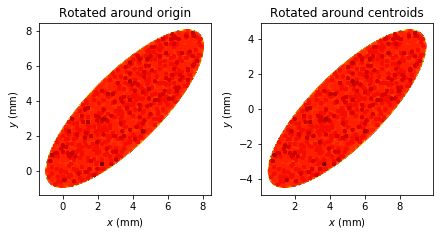

In [7]:
from distgen.transforms import rotate2d
gen=Generator(filename,verbose=0)

obeam = gen.beam()
scale(obeam,'x',3.0)
translate(obeam,'x',5*unit('mm'))
rotate2d(obeam, 'x:y', 45*unit('deg'))

cbeam = gen.beam()
scale(cbeam,'x',3.0)
translate(cbeam,'x',5*unit('mm'))
rotate2d(cbeam, 'x:y', 45*unit('deg'), origin='centroid')

fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True)
plot_2d(obeam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,ax=ax[0],axis="equal");
ax[0].set_title('Rotated around origin');

plot_2d(cbeam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,ax=ax[1],axis="equal");
ax[1].set_title('Rotated around centroids');

# Shear

The shear operation allows one to apply a sheer in a 2D subspace according of the form:

$v\rightarrow v + \alpha u$

This can be useful in a variety of cases such as drifting particles.

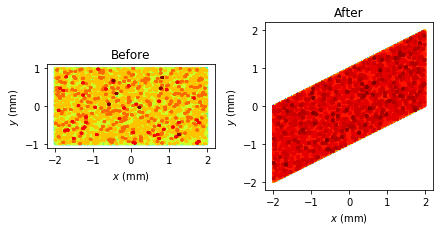

In [8]:
from distgen.transforms import shear
gen=Generator('data/x.y.uniform.in.json',verbose=0)
beam1=gen.beam()

beam2=gen.beam()
shear(beam2,'x:y',0.5)

fig, ax = plt.subplots(1, 2, constrained_layout=True)
plot_2d(beam1,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[0]);
ax[0].set_title('Before')

plot_2d(beam2,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal",ax=ax[1]);
ax[1].set_title('After');

Magnetizing a cylindrical beam provides a more physically relevant application of the sheer function.  Here the magnetization 
$\mathcal{L}$
is added to the particle momentum in the form
$p_x\rightarrow p_x + \frac{\mathcal{L}}{\sigma_{x,y}^2}y$
and $p_y\rightarrow p_y - \frac{\mathcal{L}}{\sigma_{x,y}^2}x$.  This results in a transverse emittance of
$\sqrt{\epsilon_{n,x,uncor}^2 + \mathcal{L}^2}$.  Note that using the definitions of cylindrical variables it is possible to show this is equivalent to a sheer of 
$p_{\theta}\rightarrow p_{\theta}-\frac{\mathcal{L}}{\sigma_{x,y}^2}r$. 

For symplicity, a magnetization function has been defined to perform the above transform given the magnetization $\mathcal{L}$.  Currently this assumes a cylindrically symmetric bunch.

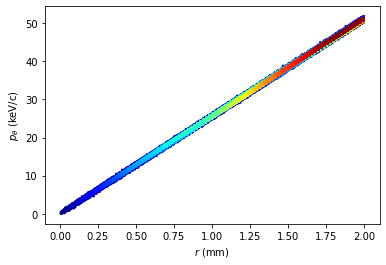

In [9]:
from distgen.physical_constants import MC2
from distgen.transforms import magnetize

Lmag = -50*unit('micrometers')*MC2.magnitude*unit("eV/c")
gen = Generator(filename,verbose=0)
beam = gen.beam()
magnetize(beam,'r:ptheta',Lmag)

plot_2d(beam,1,"r",units["r"],"ptheta",units["px"],'scatter_hist2d',nbins=100);

# Polynomial

It is possible to apply a polynomial map in one beam variable to a second using the polynomial function:

$p \rightarrow p + \sum_{n=0}^N a_n (x-\mathcal{O})^n$.  

Here $p_i$ is the dependent variable before the transformation (this term can be left out by specifying the keyword zero_dependent_var=True),  the $a_n$ specify the polynomial coefficients, and $\mathcal{O}$ is the expansion origin.  In the example used below, a quartic polynomial in $z$ is applied to $p_z$ mimicing the effect of an RF cavity:

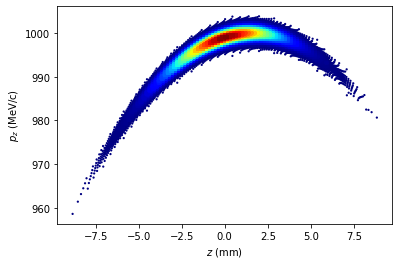

In [10]:
from distgen.generator import Generator
from distgen.physical_constants import pi,c
from distgen.transforms import polynomial
import numpy as np
gen=Generator('data/gaussian.in.json',verbose=0)
beam = gen.beam()

V0 = 1000*unit('MeV/c')
w = 2*pi*1.3*unit('GHz')
k = w/c
phi = 2.5*unit('deg')
coeffs = [V0, 0.0*unit('eV/c / meter'), -0.5*V0*k**2]
beam = polynomial(beam,'z:pz', coeffs, origin=phi/k)

plot_2d(beam,1,"z",units["z"],"pz",units["pz"],'scatter_hist2d',nbins=100);

# Cosine

It is often convenient to impart a cosine like energy spread to beam's longitudinal momentum.  This can be accomplished using the cosine transform:

$p \rightarrow p + A\cos(\omega v + \phi)$.

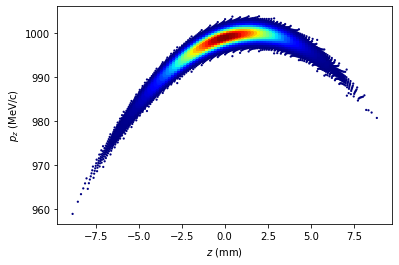

In [11]:
from distgen.generator import Generator
from distgen.physical_constants import pi,c
from distgen.transforms import cosine
import numpy as np
gen=Generator('data/gaussian.in.json',verbose=0)
beam = gen.beam()

V0 = 1000*unit('MeV/c')
w = 2*pi*1.3*unit('GHz')
k = w/c
phi = -2.5*unit('deg')
beam = cosine(beam,'z:pz', amplitude=V0, phase=phi, omega = k)

plot_2d(beam,1,"z",units["z"],"pz",units["pz"],'scatter_hist2d',nbins=100);

# Setting Twiss parameters 

Often for beams at energy the user may wish to set beam Twiss parameters $\beta$, $\alpha$, and $\epsilon$ for a desired 2D phase space.

Initial Horizontal Twiss params:
beta: 999.999 m, alpha: 0.000, eps: 1.000 nm

Final Horizontal Twiss params:
beta: 12.500 m, alpha: -1.000, eps: 2.000 nm


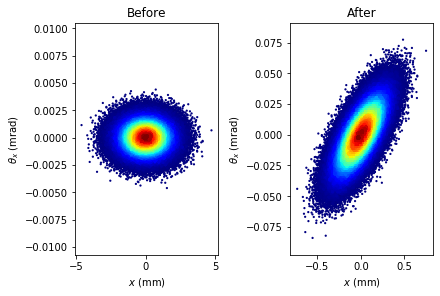

In [12]:
from distgen.transforms import set_twiss, translate
from distgen.generator import Generator
filename = "data/gaussian.in.json"

gen = Generator(filename, verbose=0) 
gen.input['transforms']={'boost':{'type':'translate', 
                         'variables':'pz', 
                         'params':{'delta': {'value':1, 'units':'GeV/c',}}}}

beam = gen.beam()

beta = 12.5*unit('m')
alpha = -1*unit('')
eps = 2*unit('nm')

beam2 = gen.beam()
beam2 = set_twiss(beam2, 'x', beta, alpha, eps)

print('Initial Horizontal Twiss params:')
print('beta: {:0.3f~P}'.format(beam.beta('x'))+', alpha: {:0.3f~P}'.format(beam.alpha('x'))+', eps: {:0.3f~P}'.format((beam.emitt('x','geometric')).to('nm')))

fig, ax = plt.subplots(1, 2, constrained_layout=True)
plot_2d(beam,1,"x",units["x"],"thetax",units["thetax"],'scatter_hist2d',nbins=100,ax=ax[0]);
ax[0].set_title('Before')

plot_2d(beam2,1,"x",units["x"],"thetax",units["thetax"],'scatter_hist2d',nbins=100,ax=ax[1]);
ax[1].set_title('After');

print('\nFinal Horizontal Twiss params:')
print('beta: {:0.3f~P}'.format(beam2.beta('x'))+', alpha: {:0.3f~P}'.format(beam2.alpha('x'))+', eps: {:0.3f~P}'.format((beam2.emitt('x','geometric')).to('nm')))